In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [2]:
def map_edt(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [3]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [4]:
#scope_name = 'Tweez scope'
scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT107&pLPT41'
pos = 0

In [5]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [6]:
fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos0.ome.tif'

In [18]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

In [19]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')
poss = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')].Position.unique()
poss

array([ 0,  1,  2,  5,  6,  9, 14, 16, 17, 19, 21, 23, 24, 25, 28, 30, 31,
       32, 34, 35])

In [21]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
df_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,Quality,exp length,Colonies,Centers,Radius,radj
204,2023-12-08,Ti scope,0,MC4100,pLPT107&pLPT41,ATC-,1,10^(-5),14:18:00,20:30:00,Very good,398,1.0,"600, 600",50.0,20.0
205,2023-12-08,Ti scope,1,MC4100,pLPT107&pLPT41,ATC-,1,10^(-5),14:18:00,20:30:00,Very good,398,1.0,"610, 600",100.0,20.0
206,2023-12-08,Ti scope,2,MC4100,pLPT107&pLPT41,ATC-,1,10^(-5),14:18:00,20:30:00,Very good,398,1.0,"610, 590",50.0,30.0
209,2023-12-08,Ti scope,5,MC4100,pLPT107&pLPT41,ATC-,1,10^(-5),14:18:00,20:30:00,Very good,398,2.0,"525, 355",50.0,20.0
210,2023-12-08,Ti scope,6,MC4100,pLPT107&pLPT41,ATC-,1,10^(-5),14:18:00,20:30:00,Very good,398,1.0,"605, 600",50.0,40.0


In [10]:
path_im = os.path.join(path, fname)
path_results = os.path.join(path, folder_results, f"pos{pos}")

In [11]:
#fname = '10x_1.0x_pAAA_-6_1_MMStack_Pos6.ome.tif'
im_all = imread(path_im)
#im_all = im_all.transpose([0,2,3,1])
#im_all = im_all[:,:,:,:ph_chn]
#im_all = imread(path_im)


In [12]:
im_all = im_all[:,:,:,:ph_chn]
nt,nx,ny,nc = im_all.shape
print(im_all.shape)

(398, 1200, 1200, 3)


In [13]:
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

In [14]:
path_results = os.path.join(path, folder_results, f"pos{pos}")
edt = np.load(os.path.join(path_results,'edt.npy'))
edt = edt[:,:,:]

In [43]:
fname

'2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos0.ome.tif'

In [40]:
## Just when fluo_chns = 3
nr = 64
rw = 16
rs = np.linspace(rw, edt.max(), nr)

cov = np.zeros((nt,nr,nc,nc))
corr = np.zeros((nt,nr,nc))
mean = np.zeros((nt,nr,nc))
for t in range(nt):
    for ri in range(nr):
        tedt = edt[t,:,:]
        idx = np.abs(tedt - rs[ri]) < rw        
        if np.sum(idx)>0:
            #plt.figure()
            if fluo_chns == 3:
                ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
                ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
                x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
                C = np.cov(np.stack([x, y, z]))
                cov[t,ri,:,:] = C
                corr[t,ri,0] = np.corrcoef(x, y)[0,1]
                corr[t,ri,1] = np.corrcoef(x, z)[0,1]
                corr[t,ri,2] = np.corrcoef(y, z)[0,1]
                mean[t,ri,rfp_chn] = x.mean()
                mean[t,ri,yfp_chn] = y.mean()
                mean[t,ri,cfp_chn] = z.mean()
            elif fluo_chns == 2:                
                ntim0 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim1 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]               
                x,y = ntim0[idx], ntim1[idx]
                C = np.cov(np.stack([x, y]))
                cov[t,ri,:,:] = C
                corr[t,ri,0] = np.corrcoef(x, y)[0,1]
                corr[t,ri,1] = np.corrcoef(y, x)[0,1]
                mean[t,ri,yfp_chn] = x.mean()
                mean[t,ri,cfp_chn] = y.mean()
                
np.save(os.path.join(path_results, 'cov.npy'), cov)            
np.save(os.path.join(path_results, 'corr.npy'), corr)
np.save(os.path.join(path_results, 'mean.npy'), mean)

/tmp/ipykernel_535170/1123376293.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(np.stack([x, y, z]))
/home/campus.ncl.ac.uk/c1046372/.conda/envs/popdyn/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/campus.ncl.ac.uk/c1046372/.conda/envs/popdyn/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/campus.ncl.ac.uk/c1046372/.conda/envs/popdyn/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


In [41]:
corr_map = np.zeros_like(corr)
mean_map = np.zeros_like(mean)
for c in range(fluo_chns):
    corr_map[:,:,c] = warp(corr[:,:,c], map_edt, {'edt':edt, 'rs':rs})
    mean_map[:,:,c] = warp(mean[:,:,c], map_edt, {'edt':edt, 'rs':rs})
corr_map[np.isnan(corr)] = np.nan
mean_map[np.isnan(mean)] = np.nan

In [21]:
np.save(os.path.join(path_results, 'corr_map.npy'), corr_map)
np.save(os.path.join(path_results, 'mean_map.npy'), mean_map)

In [22]:
df_pos.index.values

array([55, 56, 62, 64, 66, 67, 68])

In [42]:
corr.shape

(398, 64, 3)

#### Correlation kymos

pos0


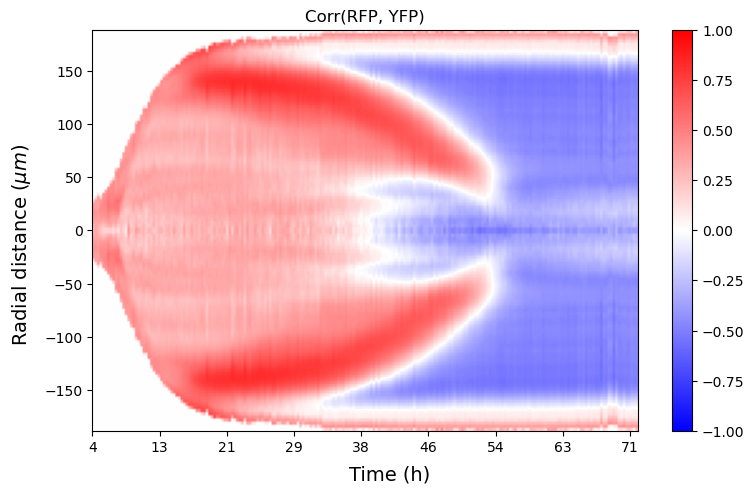

In [163]:
#radius = edt.max(axis=(1,2))
for j in [240]:#df_pos.index.values:
    pos = df_pos.loc[j, 'Position']
    print(f'pos{pos}')
    # open corr kymo or use the current one 
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    path = os.path.join(path_ext, scope_name, exp_date)
    # wdlkymo_rho = np.load(os.path.join(path, folder_results, f'pos{pos}', 'wdlkymo_rho.npy'))
       
    time_im = df_pos.loc[j, 't_im']
    time_incub = df_pos.loc[j, 't_incub']
    
    delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
    delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)
    
    # Calculate the difference
    incub_time_s = delta_im - delta_incub
    incub_time_n = incub_time_s.total_seconds() / 60
    
    time_points = np.arange(0, df_pos.loc[j, 'exp length']) * 10 + incub_time_n
    time_strings = [f"{int(tp // 60)}" for tp in time_points]  # Show only hours

    # Select labels at intervals (e.g., every 75 points)
    interval = 50
    indices = np.arange(0, len(time_points), interval)
    selected_time_strings = [time_strings[i] for i in indices]
    
    # Plotting
    plt.figure(figsize=(8, 5))
    t0 = 0

    if fluo_chns == 3:
        plt.figure(figsize=(12, 9))
        
        ax1 = plt.subplot(3, 1, 1)
        plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
                   extent=[t0, nt, -edt.max(), edt.max()], 
                   aspect='auto', 
                   cmap='bwr', 
                   vmin=-1, 
                   vmax=1)
        #plt.plot(np.arange(nt), radius, 'w')
        #plt.plot(np.arange(nt), -radius, 'w')
        plt.title('Corr(RFP, YFP)')
        plt.colorbar()

        ax2 = plt.subplot(3, 1, 2)
        plt.imshow(np.hstack([corr_map[t0:, ::-1, 1], corr_map[t0:, :, 1]]).transpose(), 
                   extent=[t0, nt, -edt.max(), edt.max()],  
                   aspect='auto', 
                   cmap='bwr', 
                   vmin=-1, 
                   vmax=1)
        #plt.plot(np.arange(nt), radius, 'w')
        #plt.plot(np.arange(nt), -radius, 'w')
        plt.title('Corr(RFP, CFP)')
        plt.colorbar()
        
        ax3 = plt.subplot(3, 1, 3)
        plt.imshow(np.hstack([corr_map[t0:, ::-1, 2], corr_map[t0:, :, 2]]).transpose(), 
                   extent=[t0, nt, -edt.max(), edt.max()],  
                   aspect='auto', 
                   cmap='bwr', 
                   vmin=-1, 
                   vmax=1)
        #plt.plot(np.arange(nt), radius, 'w')
        #plt.plot(np.arange(nt), -radius, 'w')
        plt.title('Corr(YFP, CFP)')
        plt.colorbar()

        # Set x-ticks and labels
        for ax in [ax1, ax2, ax3]:
            ax.set_xticks(indices)
            ax.set_xticklabels(selected_time_strings)

        # Add shared x and y labels
        plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
        plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
        
        plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
        plt.show()

    elif fluo_chns == 2:
        plt.figure(figsize=(4, 3))
        
        ax1 = plt.subplot(1, 1, 1)
        plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
                   extent=[t0, nt, -edt.max(), edt.max()], 
                   aspect='auto', 
                   cmap='bwr', 
                   vmin=-1, 
                   vmax=1)
        #plt.plot(np.arange(nt), radius, 'w')
        #plt.plot(np.arange(nt), -radius, 'w')
        plt.title('Corr(RFP, YFP)')
        plt.colorbar()

        ax1.set_xticks(indices)
        ax.set_xticklabels(selected_time_strings)

        # Add shared x and y labels
        plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
        plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
        
        plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
        plt.show()
        

In [179]:
#single
corr_map = np.load('/media/c1046372/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_15/results/pos0/corr_map.npy')
# triple
#corr_map = np.load('/media/c1046372/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_04/results/pos0/corr_map.npy')

In [180]:
corr_map.shape

(216, 64, 2)

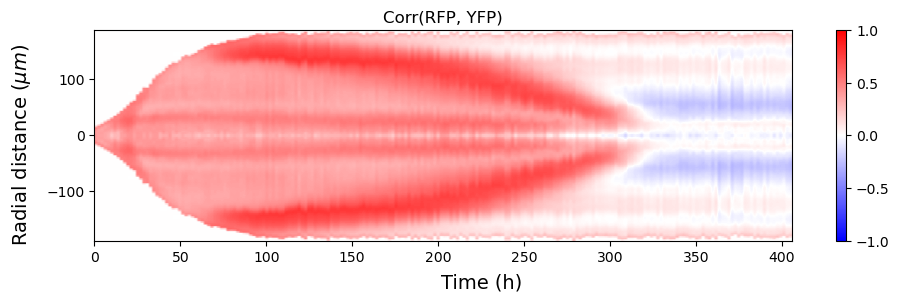

In [192]:
t0=0
plt.figure(figsize=(10, 3))
ax1 = plt.subplot(1, 1, 1)
plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
#plt.plot(np.arange(nt), radius, 'w')
#plt.plot(np.arange(nt), -radius, 'w')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

#ax1.set_xticks(indices)
#ax1.set_xticklabels(selected_time_strings)

# Add shared x and y labels
plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
plt.savefig('kymotest.png')
plt.show()

In [183]:
corr_map = np.load('/media/c1046372/Expansion/Thesis GY/3. Analyzed files/Tweez scope/2023_12_04/results/pos0/corr_map.npy')

In [26]:
t0 = 50
j = 56
time_im = df_pos.loc[j, 't_im']
time_incub = df_pos.loc[j, 't_incub']

delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)

# Calculate the difference
incub_time_s = delta_im - delta_incub
incub_time_n = incub_time_s.total_seconds() / 60

time_points = np.arange(t0, df_pos.loc[j, 'exp length']) * 10 + incub_time_n
time_strings = [f"{int(tp // 60)}" for tp in time_points]  # Show only hours

# Select labels at intervals (e.g., every 75 points)
interval = 50
indices = np.arange(0, len(time_points), interval)
selected_time_strings = [time_strings[i] for i in indices]

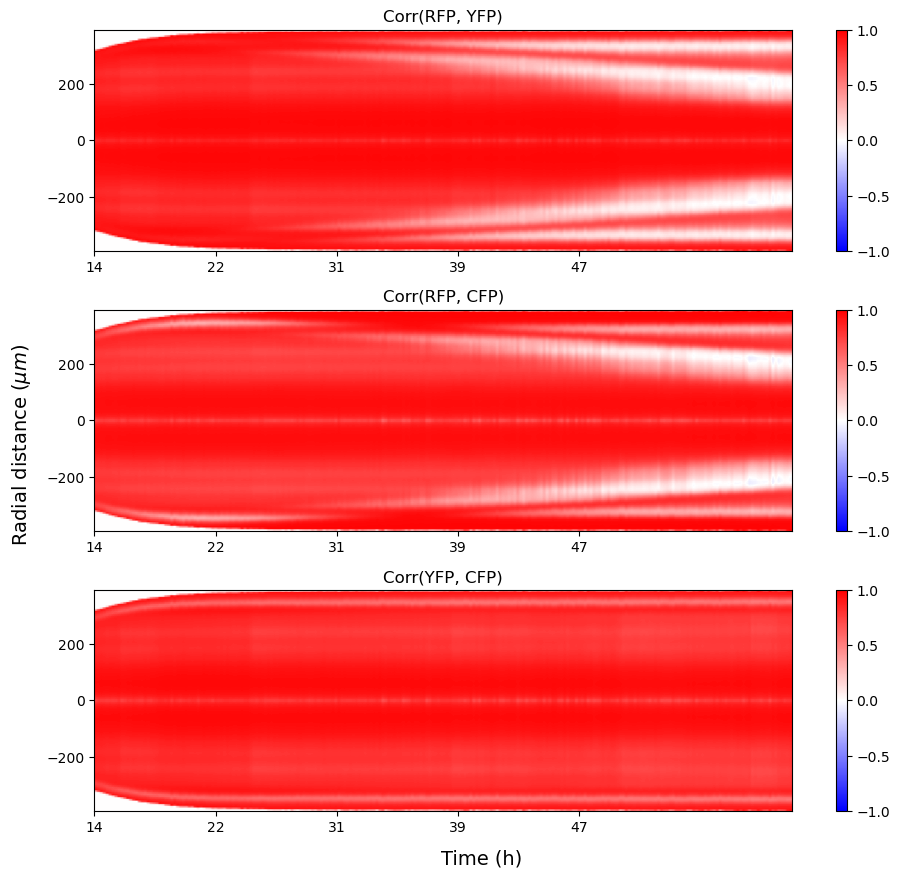

In [27]:

plt.figure(figsize=(10, 9))

ax1 = plt.subplot(3, 1, 1)
plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
#plt.plot(np.arange(nt), radius, 'w')
#plt.plot(np.arange(nt), -radius, 'w')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

ax2 = plt.subplot(3, 1, 2)
plt.imshow(np.hstack([corr_map[t0:, ::-1, 1], corr_map[t0:, :, 1]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
#plt.plot(np.arange(nt), radius, 'w')
#plt.plot(np.arange(nt), -radius, 'w')
plt.title('Corr(RFP, CFP)')
plt.colorbar()

ax3 = plt.subplot(3, 1, 3)
plt.imshow(np.hstack([corr_map[t0:, ::-1, 2], corr_map[t0:, :, 2]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
#plt.plot(np.arange(nt), radius, 'w')
#plt.plot(np.arange(nt), -radius, 'w')
plt.title('Corr(YFP, CFP)')
plt.colorbar()

# Set x-ticks and labels
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(indices)
    ax.set_xticklabels(selected_time_strings)

# Add shared x and y labels
plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
plt.savefig('kymotest_triple.png')
plt.show()

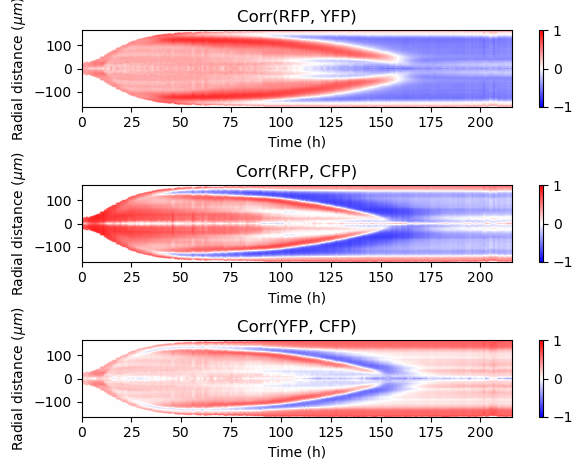

In [48]:
t0 = 0

plt.subplot(3,1,1)
plt.imshow(np.hstack([corr_map[t0:,::-1,0],corr_map[t0:,:,0]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(np.hstack([corr_map[t0:,::-1,1],corr_map[t0:,:,1]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(RFP, CFP)')
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.hstack([corr_map[t0:,::-1,2],corr_map[t0:,:,2]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(YFP, CFP)')
plt.colorbar()

plt.tight_layout()

#### Mean fluo kymos

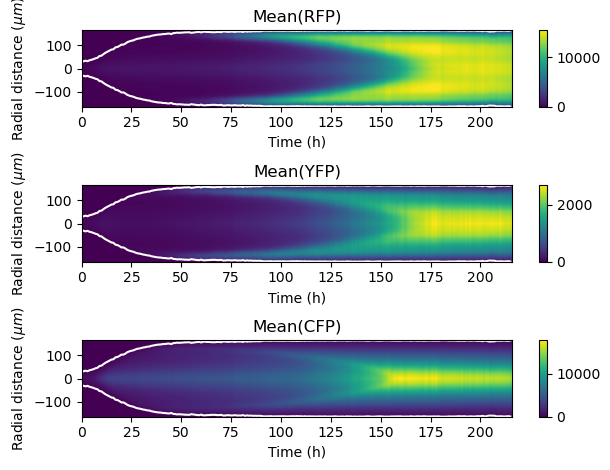

In [71]:
t0 = 0

radius = edt.max(axis=(1,2))
#plt.plot(cx - radius, np.arange(nt), 'w')

plt.subplot(3,1,1)
plt.imshow(np.hstack([mean_map[t0:,::-1,rfp_chn],mean_map[t0:,:,rfp_chn]]).transpose(), 
                   extent=[0,nt,-edt.max(),edt.max()], 
                   aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(RFP)')
plt.colorbar(aspect=10)

plt.subplot(3,1,2)
plt.imshow(np.hstack([mean_map[t0:,::-1,yfp_chn],mean_map[t0:,:,yfp_chn]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(YFP)')
plt.colorbar(aspect=10)

plt.subplot(3,1,3)
plt.imshow(np.hstack([mean_map[t0:,::-1,cfp_chn],mean_map[t0:,:,cfp_chn]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(CFP)')
plt.colorbar(aspect=10)

plt.tight_layout()

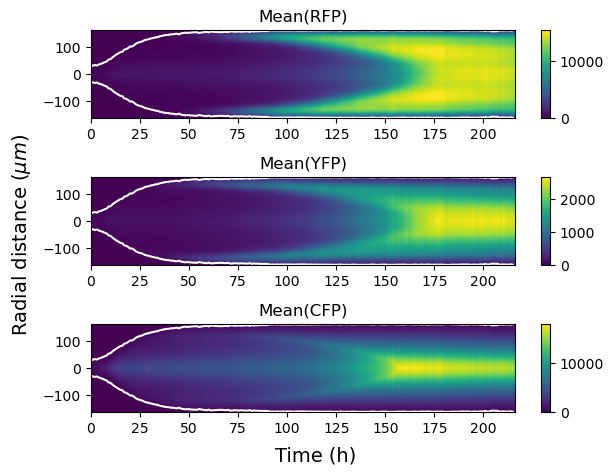

In [75]:
t0 = 0

plt.subplot(3, 1, 1)
plt.imshow(np.hstack([mean_map[t0:, ::-1, rfp_chn], mean_map[t0:, :, rfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(RFP)')
plt.colorbar(aspect=10)

plt.subplot(3, 1, 2)
plt.imshow(np.hstack([mean_map[t0:, ::-1, yfp_chn], mean_map[t0:, :, yfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(YFP)')
plt.colorbar(aspect=10)

plt.subplot(3, 1, 3)
plt.imshow(np.hstack([mean_map[t0:, ::-1, cfp_chn], mean_map[t0:, :, cfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(CFP)')
plt.colorbar(aspect=10)

# Remove individual x and y labels
plt.xlabel('')
plt.ylabel('')

# Add shared x and y labels
plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
plt.show()
